## GTSRB Traffic Sign Classifier

### 1. Loading and Preprocessing the data

#### 1.1 Loading data

In [1]:
#necessary libraries
import pandas as pd #to load .csv files
from PIL import Image # to read .png file and resize them
import os # to locate files 
import numpy as np # to store PIL images as arrays

In [2]:
train_df=pd.read_csv("Train.csv") ##labels of training images

In [3]:
##This csv file contains class ID of images to classify them and their paths to connect them to their class ID in this csv file.
train_df

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


#### 1.2 Preprocessing

In [4]:
# now loading images by Path in train_df
base_directory= "Downloads/GTSRB dataset/"
images=[]
classID=[]
for i in train_df["Path"]:
    image_path=os.path.join(base_directory,i) #locates each image 
    img= Image.open(image_path) # loads each image in memory for operations like resize
    img=img.resize((32,32)) # resize each image to 32*32 pixels 
    img_array=np.array(img) # convert img to array so DL models can work with it
    images.append(img_array) #store in a list
    # get corresponding class ID of the images
    ID=train_df.loc[train_df["Path"]==i,"ClassId"].values[0]
    #store in a list
    classID.append(ID)

In [5]:
#checking if images are of write size (32,32,3) 32* 32 pixels for each and 3 is for color channels (RGB). 39209 is total number of images. 
print(np.array(images).shape)
# Normalize images. It means scaling images; it is done so that models train faster and provide more consistent and correct outputs. 
images=list(np.array(images)/255)
# check again
print("After Normalization: ",np.array(images).shape)

(39209, 32, 32, 3)
After Normalization:  (39209, 32, 32, 3)


In [6]:
#no data was lost and images have been normalized which can be checked by
print(images[0].max())
#maximum should be less than 1 as normalized values lie between 0 and 1.

0.47058823529411764


In [7]:
# storing images and their corresponding class ID together
df=pd.DataFrame({
    "Class ID": classID,
    "Images": images
})
df

,Class ID,Images
0,20,"[[[0.1803921568627451, 0.2, 0.2196078431372549..."
1,20,"[[[0.1843137254901961, 0.19607843137254902, 0...."
2,20,"[[[0.2, 0.19607843137254902, 0.223529411764705..."
3,20,"[[[0.19215686274509805, 0.19215686274509805, 0..."
4,20,"[[[0.19607843137254902, 0.19607843137254902, 0..."
...,...,...
39204,42,"[[[0.047058823529411764, 0.043137254901960784,..."
39205,42,"[[[0.043137254901960784, 0.03529411764705882, ..."
39206,42,"[[[0.043137254901960784, 0.043137254901960784,..."
39207,42,"[[[0.050980392156862744, 0.050980392156862744,..."


##### Train test split and converting to tensor 

In [8]:
#importing necessary libraries 
from sklearn.model_selection import train_test_split #to split data for training and validating
import torch #to convert data to tensors

In [9]:
# Train and test split 
x_train,x_valid,y_train,y_valid=train_test_split(images,classID,test_size=0.2,random_state=0)

In [10]:
#convert training and validating data to tensors
#converting to numpy array for faster tensor conversion 
x_train=np.array(x_train)
x_valid=np.array(x_valid)
y_train=np.array(y_train)
y_valid=np.array(y_valid)
#converting to tensor 
x_train_tensor=torch.tensor(x_train,dtype=torch.float32)
x_valid_tensor=torch.tensor(x_valid,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.int64)
y_valid_tensor=torch.tensor(y_valid,dtype=torch.int64)

In [11]:
# pytorch expects tensor shape as (no. of images,channels,height,width)
print("Shape before(no. of images,height,width,channels): ",x_train_tensor.shape)
#changing positions:
x_train_tensor=x_train_tensor.permute(0,3,1,2)
x_valid_tensor=x_valid_tensor.permute(0,3,1,2)
print("Shape after change(no. of images,channels,height,width): ",x_train_tensor.shape)

Shape before(no. of images,height,width,channels):  torch.Size([31367, 32, 32, 3])
Shape after change(no. of images,channels,height,width):  torch.Size([31367, 3, 32, 32])


##### Creating Train dataset, valid dataset and batches.

In [12]:
#necessary libraries 
from torch.utils.data import DataLoader # for loading data in batches and shuffling
from torch.utils.data import TensorDataset # for creating train and test datasets

In [13]:
#tensor dataset pairs images and classID together
#creating train dataset 
train_dataset=TensorDataset(x_train_tensor,y_train_tensor)
#creating valid dataset
valid_dataset=TensorDataset(x_valid_tensor,y_valid_tensor)

In [14]:
#creating batches in dataset for faster loading of data for models to train(by parallel processing) and shuffling the training data for each epoch. 
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=64)

In [15]:
#check if shape format is correct
for images, labels in train_loader:
    print(images.shape)  # Should print (batch_size, 3, 32, 32)
    print(labels.shape)  # Should print (batch_size,)
    break  # to inspect a single batch

torch.Size([64, 3, 32, 32])
torch.Size([64])


### 2. Build Model

#### 2.1 Model definition 

In [16]:
# importing necessary libraries
import torch.nn as nn # to define CNN model
from torch.optim import Adam # An algorithm to optimize learning of model from loss function
import time

In [17]:
#defining the model
def get_cnn_model():
    return nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1), #first layer
    #applies 32 filters to images and thus outputs 32 filter maps of every image
    nn.BatchNorm2d(32), #normalizes the data to improve training speed
    nn.ReLU(),
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1), #hidden layer
    #outputs 64 higher level filter maps of every image from the previous 32 filter maps
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64,out_channels=96,kernel_size=3,padding=1),
    #hidden layer. outputs 96 higher level filter maps of every image from previous 64 filter maps
    nn.BatchNorm2d(96),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2), #divides the height and width of each filter maps of every image i.e. 32*32 to 16*16.
    nn.Dropout(0.3), #disables (drops) 30% of the neuron randomly to avoid overfitting.
    nn.Flatten(), #3d to 1D i.e. 64 features * 16 height *16 width for dense layers(nn.linear)
    nn.Linear(in_features=96*16*16,out_features=128), #final connected layer
    #combines all learned features across all layers
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=43) #ouput layer; predicts images to 43 output classes of road sign in data.
)

#### 2.2 Model Training and Validating

In [56]:
#function to train model
def train_model(train_loader,valid_loader,CNN_model,epoch):
    #train the model
    #define loss function
    loss_func=nn.CrossEntropyLoss()
    #optimizer
    optimizer=Adam(CNN_model.parameters()) 
    total_training_time=0 # to calculate training time
    start_time=time.time()
    for i in range(epoch):
        #training
        CNN_model.train()
        true_labels=[] # to keep track of all true labels for analysis
        predicted_labels=[] # to keep track of all predicted labels for analysis
        for images,classID in train_loader:
            optimizer.zero_grad()
            outputs=CNN_model(images)  #predicts
            loss=loss_func(outputs,classID) #calculates loss
            loss.backward() #learns from the made predictions
            optimizer.step() #optimized learning by Adam (updates weights)
        
        #Validating
        CNN_model.eval()
        correct=0
        total=0
        with torch.no_grad():
            for images,classid in valid_loader:
                outputs=CNN_model(images)
                _,predicted=torch.max(outputs,1)
                predicted_labels.extend(predicted.tolist())
                true_labels.extend(classid.tolist())
                correct+=(predicted==classid).sum().item()
                total+=classid.size(0)
    accuracy=(correct/total)*100
    end_time=time.time()
    total_training_time+=(end_time-start_time)

    return accuracy,total_training_time,predicted_labels,true_labels

##### Model Training

In [19]:
#training the model
CNN=get_cnn_model()
accuracy_training,total_training_time,predicted_labels,true_labels=train_model(train_loader,valid_loader,CNN,3)

##### Model Evaluation

In [ ]:
from sklearn.metrics import classification_report
#classification report can calculate and return a structured table of precision,recall and F1-score per class
import seaborn as sns
import matplotlib.pyplot as plt
# for visualization

In [21]:
report=classification_report(true_labels,predicted_labels,output_dict=True)
report=pd.DataFrame(report).T
report

,precision,recall,f1-score,support
0,1.000000,0.888889,0.941176,36.000000
1,0.983945,0.979452,0.981693,438.000000
2,0.990930,0.977629,0.984234,447.000000
3,0.872964,0.988930,0.927336,271.000000
4,1.000000,0.952719,0.975787,423.000000
5,0.972222,0.956284,0.964187,366.000000
6,1.000000,1.000000,1.000000,93.000000
7,0.984962,0.919298,0.950998,285.000000
8,0.928328,1.000000,0.962832,272.000000
9,0.974359,0.992537,0.983364,268.000000


#### Analysis of classification report
                                         The classification report shows that the model is robust and has a good accuracy. However, training classification report can not be used to evaluate the model alone. The training classification report shows its true value when compared with the test classification report where it helps identify weaker classes.                                                      

In [22]:
print("Total Training time of Model: ",total_training_time/60,"minutes")
total_training_time

Total Training time of Model:  17.400458467006683 minutes


1044.027508020401

### 3. Testing Model

#### 3.1 Preprocessing testing data

In [23]:
test_df=pd.read_csv("Test.csv")
test_direc="Downloads/GTSRB dataset/"
test_images=[]
labels=[]
for i in test_df["Path"]:
    image_Path=os.path.join(test_direc,i)
    image=Image.open(image_Path)
    image=image.resize((32,32)) #resize
    image=np.array(image)/255 #normalization
    test_images.append(image)
    label=test_df.loc[test_df["Path"]==i,"ClassId"].values[0]
    labels.append(label)
#transform to tensor
labels=np.array(labels)
test_images=np.array(test_images)
testimage_tensor=torch.tensor(test_images,dtype=torch.float32)
testlabel_tensor=torch.tensor(labels,dtype=torch.long)
#permute to correct size
testimage_tensor=testimage_tensor.permute(0,3,1,2)
#Tensor dataset
test_dataset=TensorDataset(testimage_tensor,testlabel_tensor)
#dataloader
test_loader=DataLoader(test_dataset,batch_size=64)

#### 3.2 Test model

In [24]:
def model_test(CNN_model,test_loader):
    correct=0
    total=0
    true_label=[]
    predicted_label=[]
    CNN_model.eval()
    with torch.no_grad():
        for image,label in test_loader:
            outputs=CNN_model(image)
            _,predicts=torch.max(outputs,1)
            predicted_label.extend(predicts.tolist())
            true_label.extend(label.tolist())
            correct+=(predicts==label).sum().item()
            total+=label.size(0)
    accuracy=(correct/total)*100
    return accuracy,predicted_label,true_label

#### 3.3 Evaluation 

In [25]:
accuracy,predicted_label,true_label=model_test(CNN,test_loader)

In [ ]:
print("Accuracy: ",accuracy)
test_report=classification_report(true_label,predicted_label,output_dict=True)

In [27]:
test_report=pd.DataFrame(test_report).T
test_report

,precision,recall,f1-score,support
0,1.000000,0.383333,0.554217,60.000000
1,0.923280,0.969444,0.945799,720.000000
2,0.991465,0.929333,0.959394,750.000000
3,0.814607,0.966667,0.884146,450.000000
4,0.989547,0.860606,0.920583,660.000000
5,0.907760,0.984127,0.944402,630.000000
6,0.992063,0.833333,0.905797,150.000000
7,0.934579,0.888889,0.911162,450.000000
8,0.813996,0.982222,0.890232,450.000000
9,0.925926,0.989583,0.956697,480.000000


### 4 Analysis of Classification Table

#### Note: The analysis section contains analyses of different runs of the model. Due to the model's dynamic and random training and testing splits, the results of the model and hence the classification report change every time. It must be noted that even though these analyses may not relate to the current results and classification report of the model, they still represent the behavior of the model and help identify weaker classes.

In [28]:
test_report=test_report.reset_index().rename(columns={
    "index" : "Class Label",
    "precision" : "Testing Precision",
    "recall" : "Testing Recall",
    "f1-score" : "Testing F1 Score",
    "support" : "Testing Support"
})
report=report.reset_index().rename(columns={
    "index" : "Class Label",
    "precision" : "Training Precision",
    "recall":"Training Recall",
    "f1-score":"Training F1 Score",
    "support" : "Training Support"
})
report_df=pd.merge(test_report,report,on="Class Label",how="inner")

In [29]:
report_df

,Class Label,Testing Precision,Testing Recall,Testing F1 Score,Testing Support,Training Precision,Training Recall,Training F1 Score,Training Support
0,0,1.000000,0.383333,0.554217,60.000000,1.000000,0.888889,0.941176,36.000000
1,1,0.923280,0.969444,0.945799,720.000000,0.983945,0.979452,0.981693,438.000000
2,2,0.991465,0.929333,0.959394,750.000000,0.990930,0.977629,0.984234,447.000000
3,3,0.814607,0.966667,0.884146,450.000000,0.872964,0.988930,0.927336,271.000000
4,4,0.989547,0.860606,0.920583,660.000000,1.000000,0.952719,0.975787,423.000000
5,5,0.907760,0.984127,0.944402,630.000000,0.972222,0.956284,0.964187,366.000000
6,6,0.992063,0.833333,0.905797,150.000000,1.000000,1.000000,1.000000,93.000000
7,7,0.934579,0.888889,0.911162,450.000000,0.984962,0.919298,0.950998,285.000000
8,8,0.813996,0.982222,0.890232,450.000000,0.928328,1.000000,0.962832,272.000000
9,9,0.925926,0.989583,0.956697,480.000000,0.974359,0.992537,0.983364,268.000000


    ##### First Run: 
                                        let us consider class 0 as a standard to understand the performance of the model. Precision =1 of the model for class 0 implies that all images predicted for class 0 were correct; recall=0.83 implies that the model identified 83 % of the total class 0 images correctly, but it also means that the model missed 17% of the total images i.e. 17% of 60 which is 14.

                                        Let us compare this classification report to the training classification report to reveal more about the model.

                                        
    By comparing the recall and precision of each class in the testing and training phases, we can find the classes with which the model struggles.
    1. Class 0 had a recall drop from 97 % in training to 86% in testing which shows that the model may be overfitted for this class. When considering the support for this class, it can be reasoned that the cause of overfitting is the small size of training data for this class. 
    2. Similarly class 6 in the training phase had a score of 1 i.e. 100% in precision and recall, but in the testing phase precision remained approximately the same but recall dropped by 10%. This implies that the model only predicts images of class 6 when it is confident.
    3. There is a significant drop in precision for images of class 20. The model had a high precision of 98% in the training phase, but in the testing phase, precision dropped to 67%. A ~30% drop in precision is significant. However, this does not mean that the model could not identify images from class 20 as it has a high recall of 97% in the testing phase. This implies that the model was able to classify 97% of the images of class 20 correctly. The drop in precision is because many images not belonging to class 20 were predicted as of class 20, this means that when the model is not confident about the classification of an image then it predicts it as of class 20. The cause of this may be because of the fact that support for class 20 in the training phase(80) is less than the support in the testing phase(90). We can safely conclude that the model needs relearning for class 20 as the model is overpredicting class 20 which cannot be justified by less training data.  
    4.  Class 21 had a score of 100% in precision and recall in training data, but even though precision remained the same, recall dropped by 17%. The cause of this is the difference in support during the training and testing phases of the model. In the training phase, support was 69, but in the testing phase, it was 90. This implies that the model is confident in its prediction for class 21, but misses data due to less training data.
    5. Class 26 suffers the same fate as class 21. 
    6. The model is very confident about its prediction for class 27 which is shown by its high precision of 100% in both the testing and training phases, but because of this the recall of the model in the testing phase dropped by ~29%. A standard case of overfitting, the model is not generalizing well. 
    7. The model seems to miss images of class 30 indicating the recall drop of ~14%. Again, like classes 21, 26 and 27, support of the testing phase is more than that of the training phase.
    8. Classes 40 and 42 also have the same problem as classes 21,26, 27 and 30. Both classes had a recall drop of 23%. Support of the the testing phase is less than the support of the training phase especially in the case of class 42 where the support of the testing phase is twice the size of the support of the training phase. 

    Conclusion: We can classify the problems identified in the analysis in the following. 
            Less Training data problem: Classes 0, 6, 21, 26, 27, 30, 40 and 42. 
            Learning Problem: Class 20
        Note: Class 20 also has less training data when compared to the testing data, however, the difference was only 10 which can not justify the drop in precision.
        Additionally, the dataset is imbalanced as many classes have support less than 100 which makes them vulnerable to performance loss particularly recall drop. 


    ##### Second Run: 
    The weaker classes for this run were classes 0,19,18,20,26,30,39,40 and 41.
    1. Class 0 had a very low recall of ~38% which shows that this class is a key problem class for the model as it was also present in the previous run. However, this time model performed even worse for this class. 
    2. Class 19 has a precision problem, but has high recall which implies that the model has trouble identifying this class. However, it is too soon to say anything for certain. Perhaps the precision arises from other classes. 
    3. Class 18 has a drop in recall during the testing phase. However, as this class did not appear in the previous run, we cannot say anything for certain yet. 
    4. Class 20 in this run has a precision drop of 18% and a recall drop of only 5% which is similar to its state in the previous run, but milder this time. We can safely assume this class is a problem class for the model.
    5. Class 26 was present in the list of problem classes in the previous run as well. It had the same problem in the previous run. It has a high precision, but recall seems to have an approximate drop of 17% in both runs. 
    6. Class 30 has a precision drop of 24% and a recall drop of 21%. This indicates that the model has a problem learning this class, but again it may be due to other problem classes particularly 40 and 42 which performed well in this run somehow. 
    7. Class 39 has a recall drop of 26%, but a precision of 100% which indicates that the model is predicting images of class 39  only when it is confident and many images of class 39 are being misclassified probably as class 30 which may explain its precision drop. 
    8. Class 40 has a 14% precision drop and a 10% recall drop which is better than its state in the previous run where it had a 22% recall drop. 
    9. Class 41 has a 12% recall drop and a good precision. It has a very small size of support though.
    10. Class 42 has performed very well in this run. However, it has a small size of support and had a large 30% drop in recall in the previous run.

    Conclusion:
    Classes to still consider in future runs: 18,19,39,41,26
    Problem classes to augment: 0,40,42,20

### 4. Augementation

    Based on analyses of pre-augmented runs, the identified problem classes were grouped together and were augmented to test the model performance. The summary of these post-augmentation runs is as following: 
| Augmented Classes | Accuracy (%) | Notes                                                       |
| ----------------- | ------------ | ----------------------------------------------------------- |
| 0, 20, 27, 40, 42 | **97.48**    | Best raw accuracy; slight overfit in a few classes          |
| **0, 40, 30, 23** | **97.42**    | Most balanced overall; all but 2 classes above ~90% P/R      |
| 0, 20, 42, 40     | 95.94        | Class 20 overfit, others average                            |
| 0, 20, 42, 40, 41 | 95.93        | Class 41 recall drop                                        |
| 0, 42, 40, 41, 27 | 96.69        | Class 42 precision drop; class 20 okay without augmentation |
| 0, 41, 40         | 96.10        | Class 19/20/41 weak                                         |
| 0, 40             | 95.66    | Similar to 0, 41,40 run, but weaker in classes 23 and 30        |

    Summary of class based reports for the runs:
| Run (Augmented Classes) | Accuracy   | Class | Precision | Recall | Notes                                    |
| ----------------------- | ---------- | ----- | --------- | ------ | ---------------------------------------- |
| `0, 42, 41, 40, 27`     | 96.70%     | 0     | 0.933     | 0.982  | Good gain, not overfitting               |
|                         |            | 20    | 0.978     | 0.759  | NOT augmented — recall decent            |
|                         |            | 27    | 0.717     | 0.935  | Overfitting suspected                    |
|                         |            | 40    | 0.978     | 0.846  | Solid                                    |
|                         |            | 42    | 0.733     | 0.985  | High recall, low precision (overfitting) |
| `0, 20, 42, 40`         | 95.94%     | 0     | 0.917     | 1.000  | Boosted recall, solid                    |
|                         |            | 20    | 0.944     | 0.780  | Helped recall, precision still meh       |
|                         |            | 27    | 0.800     | 0.873  | NOT augmented                            |
|                         |            | 40    | 0.889     | 0.964  | High recall gain                         |
|                         |            | 42    | 0.833     | 0.949  | Slight overfitting                       |
| `20, 27, 40, 42`        | 97.48%     | 0     | 1.000     | 1.000  | NOT augmented — excellent                |
|                         |            | 20    | 0.967     | 0.664  | Over-augmented, high FP (low precision)  |
|                         |            | 27    | 0.717     | 0.977  | Strong recall, weak precision (overfit)  |
|                         |            | 40    | 0.900     | 0.976  | Excellent                                |
|                         |            | 42    | 0.878     | 0.963  | Still recall-dominant                    |
| `0, 41, 40`             | 96.10%     | 0     | 0.900     | 1.000  | Consistent gain                          |
|                         |            | 20    | 0.989     | 0.669  | NOT augmented — poor recall              |
|                         |            | 41    | 1.000     | 0.732  | Augmented, recall dropped                |
|                         |            | 40    | 0.956     | 0.851  | Slight drop in recall                    |
| `0, 40, 30, 23`         | 97.42%   | 0     | 0.933     | 1.000  | Consistent; good result                  |
|                         |          | 20    | 0.978     | 0.779  | Still a weak link (recall drops)         |
|                         |          | 23    | 0.980     | 0.955  | Excellent gain                           |
|                         |          | 30    | 0.893     | 0.905  | Huge win for a known problem class       |
|                         |          | 40    | 0.911     | 0.891  | Stable & better than many other runs     |
|                         |          | 41    | 0.767     | 0.939  | Overfit — very low precision             |

    Summary of class weights in augmentation runs:
| Class  | Consistently Benefits from Augmentation | Notes                                                            |
| ------ | --------------------------------------- | ---------------------------------------------------------------- |
| **0**  | ✅ Yes                                   | Stable gains in all runs                                         |
| **20** | ❌ No                                    | Always erratic, usually hurts recall or precision                |
| **23** | ✅ Yes                                   | First time tested, gave solid results                            |
| **30** | ✅ Yes                                   | Former weak class, now above 90% for both P/R                    |
| **40** | ✅ Yes                                   | Excellent in nearly every combo                                  |
| **41** | ❌ No                                    | Repeated overfit — recall boosts at cost of precision            |
| **42** | ❌ No                                    | Repeated overfit — recall boosts at cost of precision            |


    Based on these results, the best run (0,40,30,23) was selected to be displayed because it has a high accuracy and also has the most fairly balanced classes. 

    Note:- The results may differ as the train-test split is different each time the whole notebook is executed. The results shown here may not be exactly reproducible. 

In [69]:
#libaray to augment images
from torchvision import transforms

In [70]:
# An instance of transforms; using Compose to apply a set operations together
transform=transforms.Compose([
    transforms.RandomHorizontalFlip(), #Flips images horizontally randomly
    transforms.RandomRotation(10), #Rotates images by 10 degress randomly
    transforms.ColorJitter(brightness=0.2,contrast=0.2) #changes brightness and contrast of images.
])

In [95]:
images=[]
class_id=[]
for i in train_df["Path"]:
    img_path=os.path.join(base_directory,i)
    img=Image.open(img_path)
    ID=train_df.loc[train_df["Path"]==i,"ClassId"].values[0]
    img=img.resize((32,32)) #resize
    if ID in [0,40,30,23]:
        for _ in range(1):  # 1x augmentation
            aug_img = transform(img) # increases support for weaker classes
            images.append(np.array(aug_img)/255)
            class_id.append(ID)
    img=np.array(img)/255 #Normalization
    images.append(img)
    class_id.append(ID)
train_x,valid_x,train_y,valid_y=train_test_split(images,class_id,test_size=0.2,random_state=0) #train test split
train_x=np.array(train_x) # convert to array for faster tensor conversion
train_y=np.array(train_y)
valid_x=np.array(valid_x)
valid_y=np.array(valid_y)
tensor_train_x=torch.tensor(train_x,dtype=torch.float32) #convert to tensor
tensor_train_y=torch.tensor(train_y,dtype=torch.int64)
tensor_valid_x=torch.tensor(valid_x,dtype=torch.float32)
tensor_valid_y=torch.tensor(valid_y,dtype=torch.int64)
tensor_train_x=tensor_train_x.permute(0,3,1,2) #correct the channel position
tensor_valid_x=tensor_valid_x.permute(0,3,1,2)
Augmented_train_dataset=TensorDataset(tensor_train_x,tensor_train_y) # to tensor datasets
Augmented_valid_dataset=TensorDataset(tensor_valid_x,tensor_valid_y)
Augmented_train_loader=DataLoader(Augmented_train_dataset,batch_size=64,shuffle=True) #create data loaders
Augmented_valid_loader=DataLoader(Augmented_valid_dataset,batch_size=64)

In [96]:
Augmented_CNN=get_cnn_model()
aug_accuracy,aug_training_time,predictedlabels,truelabels=train_model(Augmented_train_loader,Augmented_valid_loader,Augmented_CNN,5)

In [97]:
aug_report=classification_report(truelabels,predictedlabels,output_dict=True)
aug_df=pd.DataFrame(aug_report).T
aug_df

,precision,recall,f1-score,support
0,1.000000,0.989247,0.994595,93.000000
1,0.993197,0.993197,0.993197,441.000000
2,1.000000,0.993576,0.996778,467.000000
3,1.000000,0.992857,0.996416,280.000000
4,1.000000,0.997602,0.998800,417.000000
5,0.975741,0.991781,0.983696,365.000000
6,1.000000,1.000000,1.000000,96.000000
7,0.996324,0.981884,0.989051,276.000000
8,0.988189,0.996032,0.992095,252.000000
9,0.990228,0.993464,0.991843,306.000000


In [98]:
print("Total Training Time of Model on Augmented data: ", aug_training_time/60, "minutes")

Total Training Time of Model on Augmented data:  30.80717806418737 minutes


##### Testing the new model

In [99]:
Aug_test_accuracy,aug_predicted_label,aug_true_label=model_test(Augmented_CNN,test_loader)

In [100]:
aug_testreport=classification_report(aug_predicted_label,aug_true_label,output_dict=True)
aug_testreport_df=pd.DataFrame(aug_testreport).T
aug_testreport_df

,precision,recall,f1-score,support
0,0.933333,1.000000,0.965517,56.000000
1,0.980556,0.976487,0.978517,723.000000
2,0.996000,0.992032,0.994012,753.000000
3,0.962222,0.997696,0.979638,434.000000
4,0.974242,0.972769,0.973505,661.000000
5,0.990476,0.909621,0.948328,686.000000
6,0.826667,1.000000,0.905109,124.000000
7,0.924444,0.978824,0.950857,425.000000
8,0.971111,0.929787,0.950000,470.000000
9,0.995833,0.957916,0.976507,499.000000


### 4. Result

    The model achieves an accuracy between 98-99% on training data and an accuracy of 96-97% on testing data. 

In [102]:
result_df=pd.DataFrame({
    "Accuracy":[aug_accuracy,Aug_test_accuracy]
},index=["Training Session","Testing Session"])
result_df

,Accuracy
Training Session,99.545901
Testing Session,97.418844


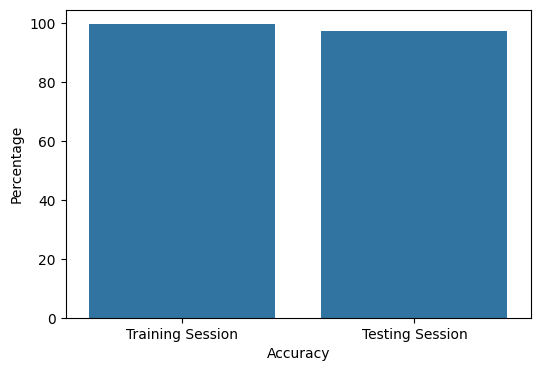

In [103]:
# barplot
plt.figure(figsize=(6,4))
sns.barplot(result_df["Accuracy"])
plt.xlabel("Accuracy")
plt.ylabel("Percentage")
plt.show()

### Extras

#### Extra 1: Model Version History

    Version 1: Initial Model
    The model architecture consisted of two convolutional layers followed by Maxpooling and two linear layers. The model performed well, achieving 98% accuracy on training data and 91% accuracy on testing data. The model has a training time of ~512 seconds. However, the model's accuracy was meeting the set goal and it was assumed that the model could not learn enough with 4 layers.  
    
    Version 2: Deeper Model
    The second version of the model added another convolutional layer to improve accuracy. However, the accuracy remained unchanged while the training time tripled (~1600 seconds). Classification Report was added to identify the performance issues better and it showed clear signs of overfitting. 
    
    Version 3: Generalization and Optimization
    This version focused on reducing the overfitting and training time of the model. Two key changes were made:
        a)Batch Normalization was added to normalize the output of each convolutional layer to reduce the load on the next layer. This improved the training speed of the model. 
        b) Dropout was added before the final linear layer which combined the learning of all three hidden layers. Dropout disabled(dropped) 30% of the neurons of the linear layer and reduced overfitting significantly. 
        This version of the model saw significant improvements in : 
        a) Accuracy of training and testing improved to 99% and 97% respectively. 
        b) Training time dropped to ~1000. 
    
    Version 4: Future Version
    A future version will include class-specific data augmentation to improve performance on underperforming classes, as identified through precision-recall analysis. 

#### Extra 2: CPU vs GPU 

    The following function can be used to compare model performance on GPU and CPU in terms of training time, latency, and throughput. However, these comparisons were not conducted in this project due to hardware and time constraints.

In [32]:
#function to train model
def train_model(device,train_loader,valid_loader,CNN_model):
    CNN_model.to(device) #transfer to given device
    #train the model
    #define loss function
    loss_func=nn.CrossEntropyLoss()
    #optimizer
    optimizer=Adam(CNN_model.parameters())
    epoch=3
    total_img=0
    total_validation_time=0
    total_training_time=0
    for i in range(epoch):
        #training
        CNN_model.train()
        true_labels=[]
        predicted_labels=[]
        start_time=time.time()
        for images,classID in train_loader:
            images=images.to(device) #transfer to given device
            classID=classID.to(device) #transfer to given device
            optimizer.zero_grad()
            outputs=CNN_model(images)  #predicts
            loss=loss_func(outputs,classID) #calculates loss
            loss.backward() #learns from the made predictions
            optimizer.step() #optimized learning by Adam (updates weights)
        
        #Validating
        CNN_model.eval()
        correct=0
        total=0
        validation_start_time=time.time()
        with torch.no_grad():
            for images,classid in valid_loader:
                images=images.to(device) #transfer to given device
                classid=classid.to(device) #transfer to given device
                outputs=CNN_model(images)
                _,predicted=torch.max(outputs,1)
                predicted_labels.extend(predicted.tolist())
                true_labels.extend(classid.tolist())
                correct+=(predicted==classid).sum().item()
                total+=classid.size(0)
        accuracy=(correct/total)*100
        end_time=time.time()
        validation_end_time=time.time()
        total_img+=total
        total_validation_time+=(end_time-validation_start_time)
        total_training_time+=(end_time-start_time)

    latency=total_validation_time/total_img
    throughput=1/latency
    return accuracy,total_training_time,latency,throughput,predicted_labels,true_labels

In [ ]:
#on CPU
CPU_CNN=get_cnn_model()
device = "cpu"
accuracy_cpu,total_training_time_cpu,latency_cpu,throughput_cpu,_,_=train_model(device,train_loader,valid_loader,CPU_CNN)
# on GPU
GPU_CNN=get_cnn_model()
device = "cuda" if torch.cuda.is_available() else "cpu"
accuracy_gpu,total_training_time_gpu,latency_gpu,throughput_gpu,_,_=train_model(device,train_loader,valid_loader,GPU_CNN)

In [ ]:
compare_df=pd.DataFrame({
    "CPU": [accuracy_cpu,total_training_time_cpu,latency_cpu,throughput_cpu],
    "GPU": [accuracy_gpu,total_training_time_gpu,latency_gpu,throughput_gpu]
},index=["Accuracy","Total_Training_Time","Latency","Throughput"])
print(compare_df.T)
compare_df=compare_df.T

In [ ]:
#visualize
x=["Accuracy","Total_Training_Time","Latency","Throughput"]
for i in x:
    plt.figure(figsize=(6,4))
    sns.barplot(compare_df[i])
    plt.title("CPU vs GPU")
    plt.xlabel(i)
    plt.ylabel("Value")